In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dfm = pd.read_csv("dfm.csv")

In [3]:
dfm = dfm.drop(['Unnamed: 0', 'name', 'artists', 'album_name', 'popularity_confidence', 'features_duration_ms'], axis=1)

In [4]:
# crea un df con due colonne genre e n. di missing values per ogni genre, ed aggiunge l'indice alle righe
missing_counts = dfm.groupby('genre')['mode'].apply(lambda x: x.isnull().sum()).reset_index()

# rinomino le colonne del df missing_counts, che orasi chiameranno genre e missing_count invece che genre e mode
missing_counts.columns = ['genre', 'missing_count']

# Crea il DataFrame df1 privo di missing values
df1 = dfm[dfm['mode'].notnull()]

# Calcola le frequenze di 0 e 1 per ciascun genere in df1
# frequencies_by_genre è un df che contiene le frequenze di 0 e 1 per ciascun genere
frequencies_by_genre = df1.groupby('genre')['mode'].value_counts(normalize=True).unstack().fillna(0)

# Sostituisci i missing values con liste di 0 e 1 basate sulle frequenze per ogni genere
for genre in dfm['genre'].unique():
    # restituisce True se c'è un missing value in mode e se è il genere in questione
    missing_values = dfm['mode'].isnull() & (dfm['genre'] == genre)
    # seleziona la giusta riga e colonna del df missing_counts e restituisce il conteggio di missing values per quel genre
    missing_count = missing_counts[missing_counts['genre'] == genre]['missing_count'].values[0]

    if missing_count > 0:
        # retituisce la coppia di frequenze per i valori 0 e 1 per il genre in questione
        frequencies = frequencies_by_genre.loc[genre]
        # crea un array di 0 e 1 estratti in base alle frequenze del genere, utilizzate come probabilità
        replacement_values = np.random.choice([0, 1], size=missing_count, p=frequencies)
        # sostituisce i missing values (True) della colonna mode con i valori dell'array precedente
        dfm.loc[missing_values, 'mode'] = replacement_values

In [5]:
dfm['time_signature'] = dfm['time_signature'].fillna(dfm['time_signature'].mode()[0])

# Partitioning

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
attributes = [col for col in dfm.columns if col != 'genre']
X = dfm[attributes].values
y = dfm['genre']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Decision Tree

In [9]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [10]:
dt = DecisionTreeClassifier()

In [11]:
%%time
dt.fit(X_train, y_train)

CPU times: total: 531 ms
Wall time: 1.25 s


DecisionTreeClassifier()

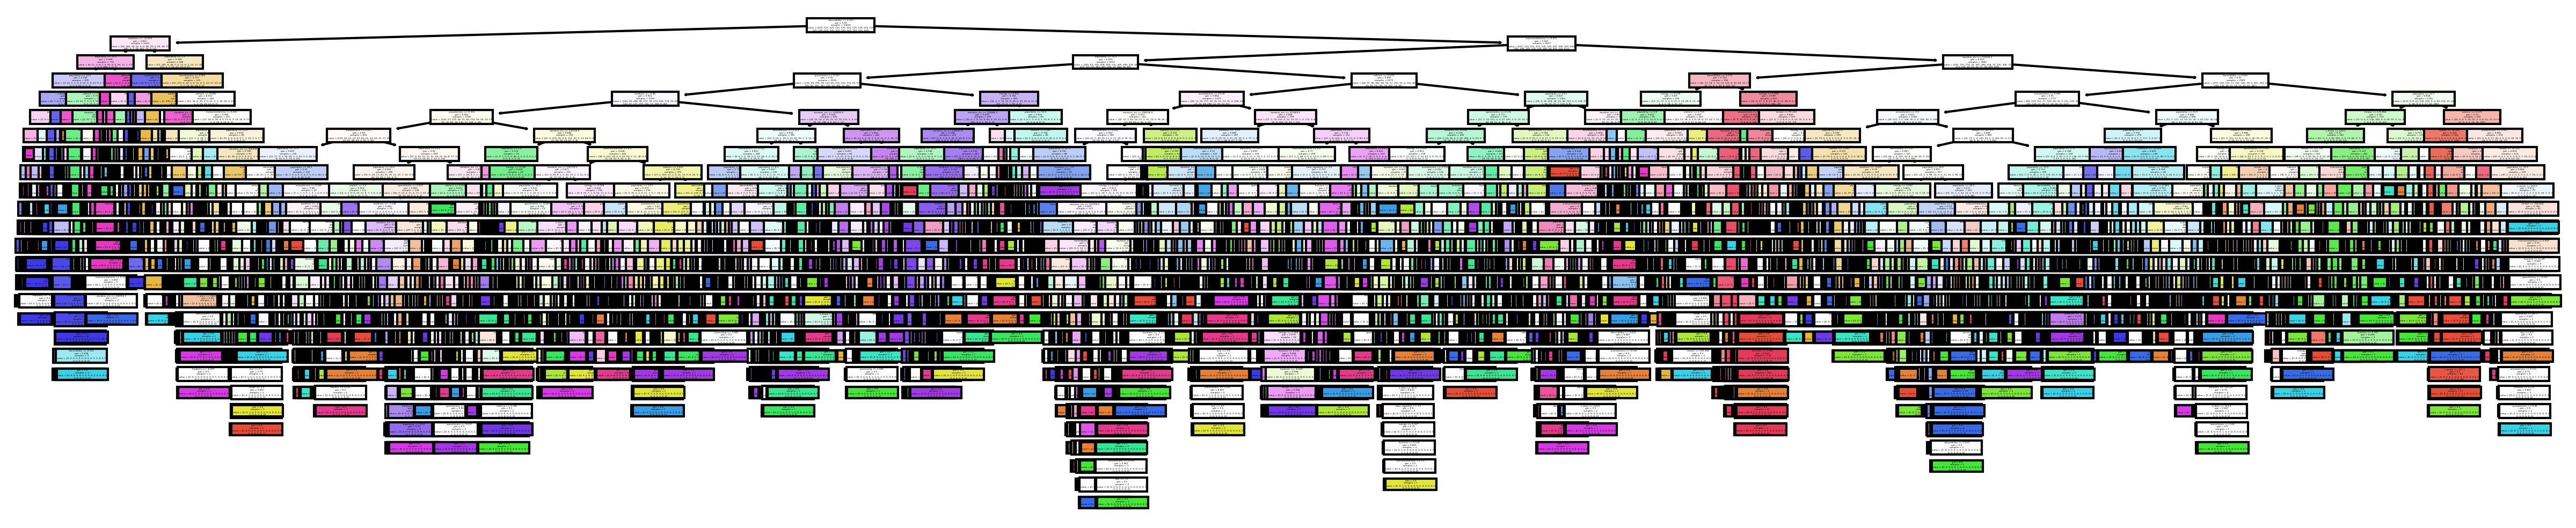

In [12]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dt, feature_names=attributes, filled=True)
plt.show()

In [13]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [14]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [15]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Test Accuracy 0.424
Test F1-score [0.24034335 0.64367816 0.44789357 0.27740492 0.27956989 0.47619048
 0.49372385 0.54988914 0.42990654 0.29234339 0.29411765 0.28314607
 0.5619469  0.41763341 0.44631579 0.33484163 0.72321429 0.21258134
 0.71759259 0.38651685]


In [16]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.23      0.25      0.24       225
  black-metal       0.67      0.62      0.64       225
    bluegrass       0.45      0.45      0.45       225
       brazil       0.28      0.28      0.28       225
    breakbeat       0.27      0.29      0.28       225
chicago-house       0.49      0.47      0.48       225
       disney       0.47      0.52      0.49       225
        forro       0.55      0.55      0.55       225
        happy       0.45      0.41      0.43       225
          idm       0.31      0.28      0.29       225
       indian       0.28      0.31      0.29       225
   industrial       0.29      0.28      0.28       225
      iranian       0.56      0.56      0.56       225
      j-dance       0.44      0.40      0.42       225
       j-idol       0.42      0.47      0.45       225
     mandopop       0.34      0.33      0.33       225
        sleep       0.73      0.72      0.72       225
      spa

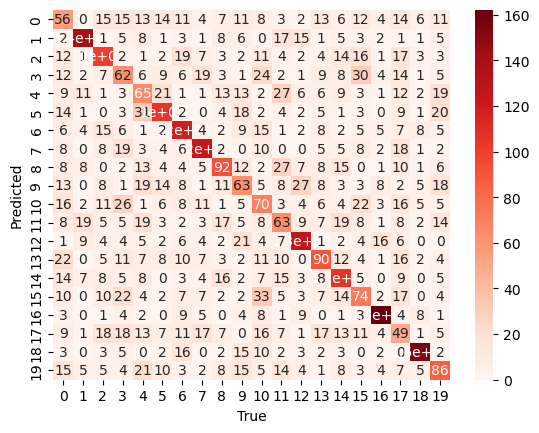

In [17]:
cf = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cf, annot=True, cmap="Reds")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

In [18]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity 0.14343047824549765
danceability 0.09595614691676702
acousticness 0.09128757474543625
loudness 0.08448161733682726
duration_ms 0.0838912154746103
valence 0.07400942959415235
instrumentalness 0.07085590616964503
speechiness 0.06446722195732854
energy 0.06291228087877135
tempo 0.06145081636245126
liveness 0.04367276442003737
n_beats 0.03694232880510152
n_bars 0.0289526054899115
processing 0.020803531224906024
key 0.019268852745128663
mode 0.0076323539851808515
time_signature 0.005023734419647604
explicit 0.004961141228599473


# Hyperparameters

In [19]:
from sklearn.model_selection import cross_val_score

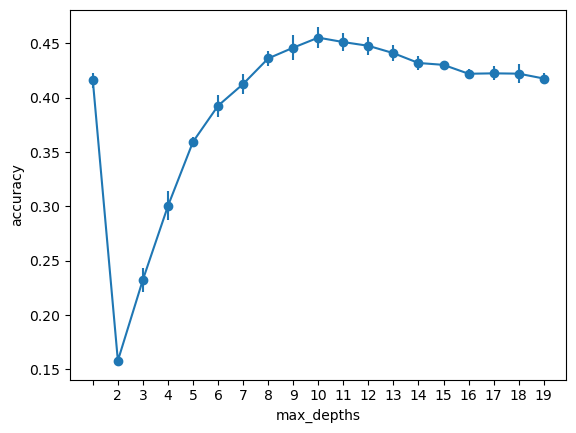

CPU times: total: 40 s
Wall time: 1min 9s


In [20]:
%%time
max_depths = [None] + list(np.arange(2, 20))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

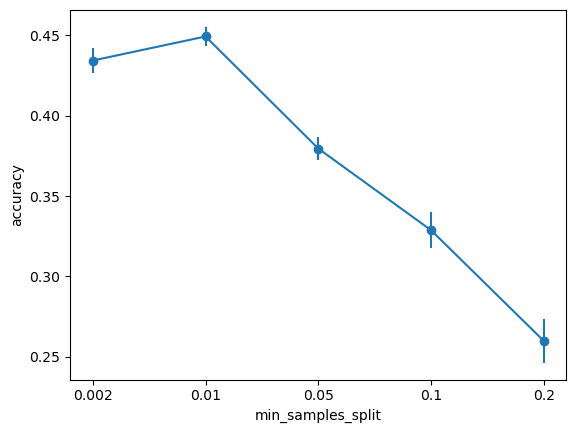

In [21]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split")
plt.ylabel("accuracy")
plt.show()

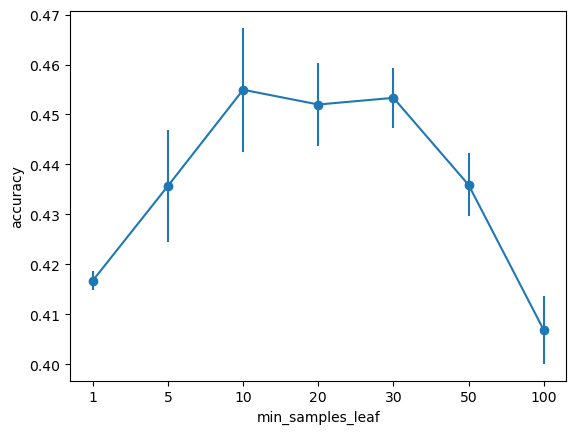

In [22]:
min_samples_leafs = [1, 5, 10, 20, 30, 50, 100]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

# Randomized search

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [24]:
%%time
param_list = {
    'max_depth': [None] + list(np.arange(2, 20)),
    'min_samples_split': [2, 5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
    'criterion': ['gini', 'entropy']
}

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_distributions=param_list,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
    n_iter=200,
    #verbose=2
)

random_search.fit(X_train, y_train)
clf = random_search.best_estimator_

CPU times: total: 9min 4s
Wall time: 28min 14s


In [25]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 30, 'min_samples_leaf': 10, 'max_depth': 15, 'criterion': 'gini'} 0.45927619047619056


In [26]:
y_test_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.4702222222222222


In [27]:
clf.score(X_test, y_test)

0.4702222222222222

In [28]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Test Accuracy 0.4702222222222222
Test F1-score [0.28256071 0.64634146 0.51143451 0.34538153 0.29450549 0.48870637
 0.53080569 0.57582418 0.44720497 0.3681592  0.29598309 0.33488372
 0.60849057 0.47342995 0.5255814  0.40088106 0.78241758 0.28372093
 0.75164835 0.44226044]


In [29]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.28      0.28      0.28       225
  black-metal       0.60      0.71      0.65       225
    bluegrass       0.48      0.55      0.51       225
       brazil       0.32      0.38      0.35       225
    breakbeat       0.29      0.30      0.29       225
chicago-house       0.45      0.53      0.49       225
       disney       0.57      0.50      0.53       225
        forro       0.57      0.58      0.58       225
        happy       0.42      0.48      0.45       225
          idm       0.42      0.33      0.37       225
       indian       0.28      0.31      0.30       225
   industrial       0.35      0.32      0.33       225
      iranian       0.65      0.57      0.61       225
      j-dance       0.52      0.44      0.47       225
       j-idol       0.55      0.50      0.53       225
     mandopop       0.40      0.40      0.40       225
        sleep       0.77      0.79      0.78       225
      spa

In [30]:
results = pd.DataFrame(random_search.cv_results_)

<Axes: xlabel='param_max_depth', ylabel='mean_test_score'>

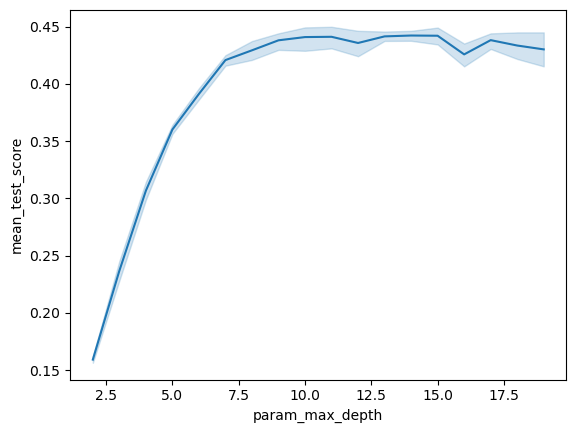

In [31]:
sns.lineplot(data=results, x="param_max_depth", y="mean_test_score")

<Axes: xlabel='param_min_samples_leaf', ylabel='mean_test_score'>

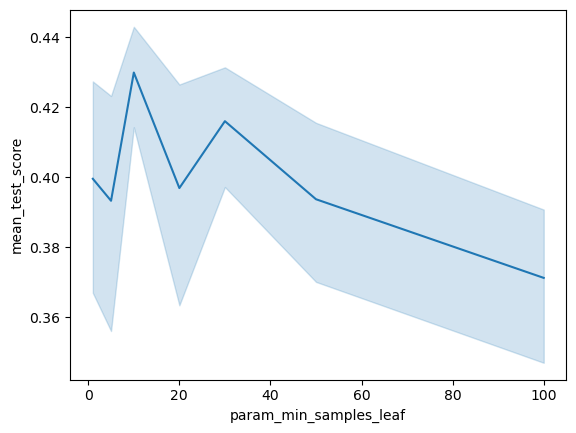

In [32]:
sns.lineplot(data=results, x="param_min_samples_leaf", y="mean_test_score")

In [33]:
zipped = zip(attributes, clf.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

popularity 0.22711858756316936
danceability 0.11588482707452752
acousticness 0.11208228904534139
duration_ms 0.10940018326989058
loudness 0.08639759763479764
instrumentalness 0.0772452580697531
valence 0.06627694336976829
energy 0.05508180995541198
speechiness 0.047790129948641395
tempo 0.046769675869360094
n_beats 0.02155531861359906
liveness 0.011493276635080821
n_bars 0.010482674005298818
processing 0.003322373521582479
key 0.003302255526553329
explicit 0.003093796726667432
mode 0.0016858026912168656
time_signature 0.001017200479339807


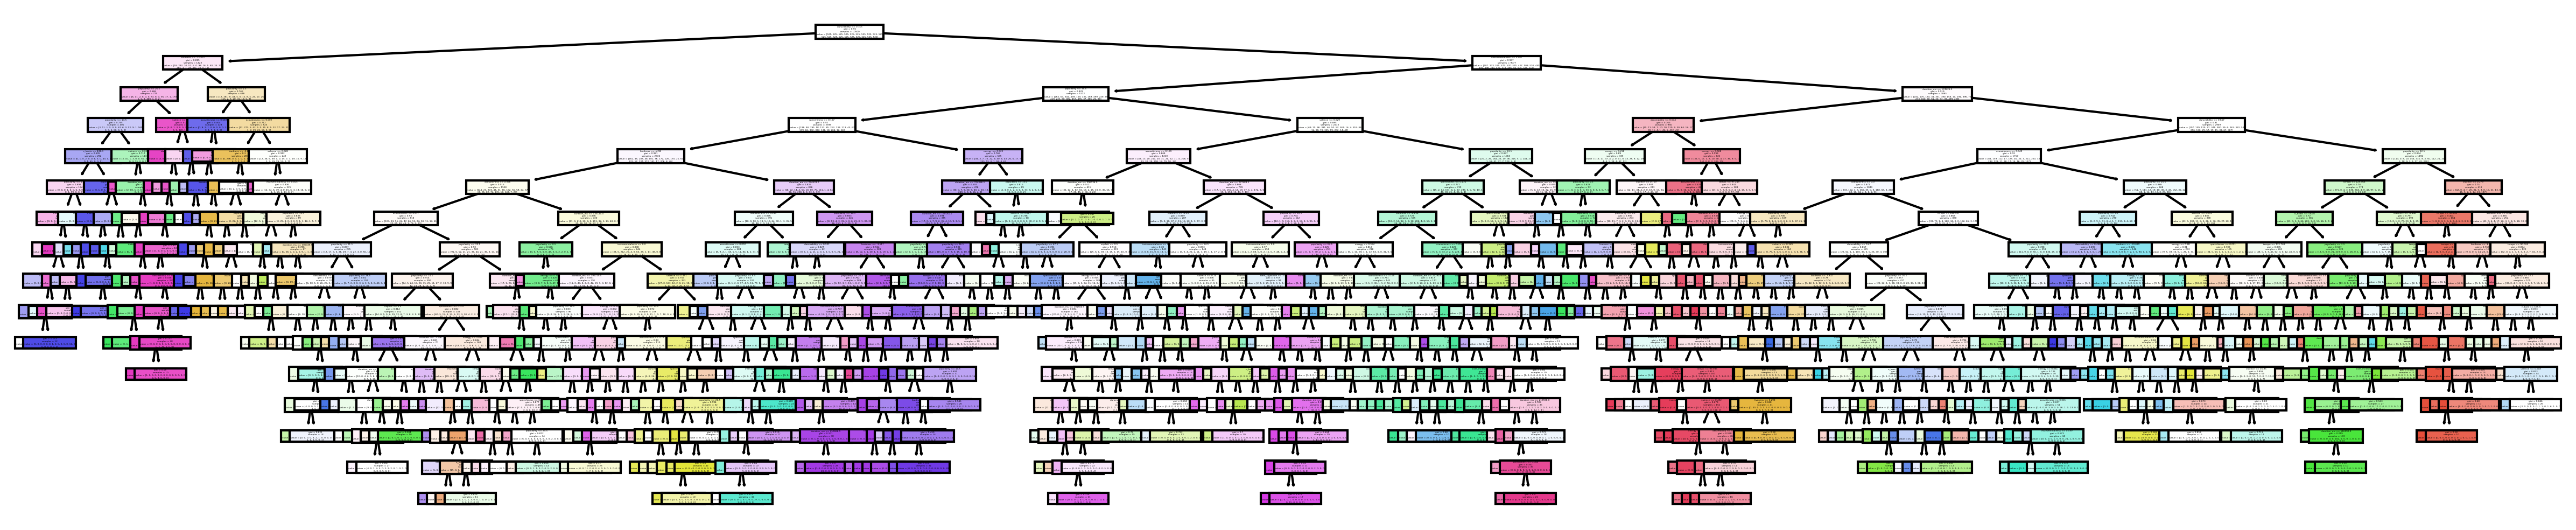

In [34]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(clf, feature_names=attributes, filled=True)
plt.show()

# ccp_alphas

In [35]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [36]:
for alpha, imp in zip(ccp_alphas, impurities):
    print(alpha, imp)

0.0 0.5117215492134914
1.3888888888888642e-05 0.5117354381023803
1.4401858304297359e-05 0.5117498399606846
1.451247165532867e-05 0.5117643524323399
1.6907437132156298e-05 0.511781259869472
1.6907437132156298e-05 0.5117981673066041
1.7198335644937767e-05 0.511815365642249
1.817387505460792e-05 0.5118335395173037
1.8243194713782568e-05 0.5118517827120175
2.262443438914017e-05 0.5118744071464066
2.2664574146210865e-05 0.5118970717205529
2.8612554176082644e-05 0.511954296828905
3.090277777777786e-05 0.5120161023844606
3.2967032967032815e-05 0.5120490694174277
4.089635854341784e-05 0.5120899657759711
4.116638078902231e-05 0.5121311321567601
4.210526315789491e-05 0.5121732374199179
4.5299641385128766e-05 0.512218537061303
4.561026007209284e-05 0.5122641473213752
4.767634509868462e-05 0.5123118236664739
4.773902751430874e-05 0.5123595626939882
4.897959183673478e-05 0.5124085422858249
4.8979591836734887e-05 0.5124575218776616
5.137480924351516e-05 0.5125088966869051
5.3030303030303025e-05 0.51

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

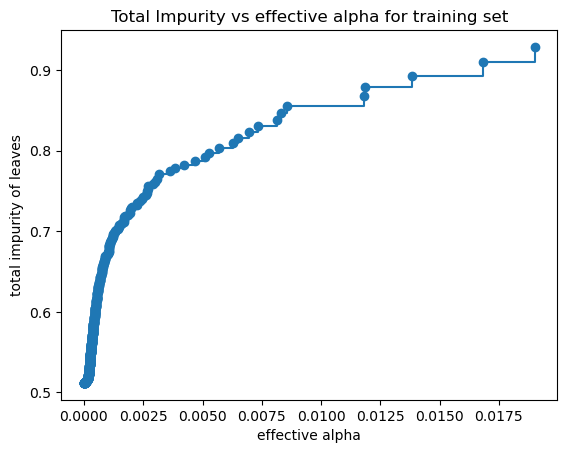

In [37]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [38]:
random_search.best_params_

{'min_samples_split': 30,
 'min_samples_leaf': 10,
 'max_depth': 15,
 'criterion': 'gini'}

In [39]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.02119343825849751


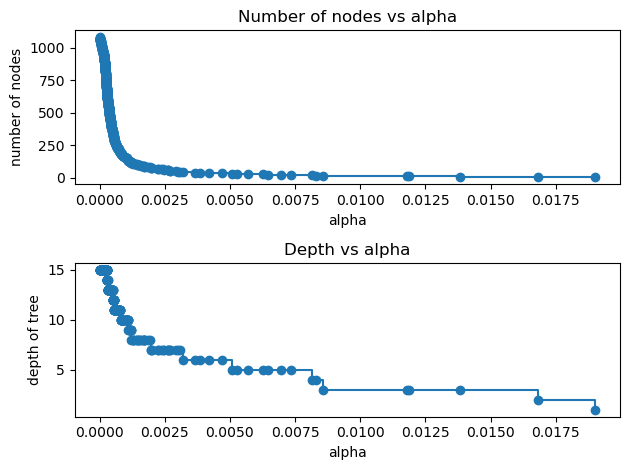

In [40]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

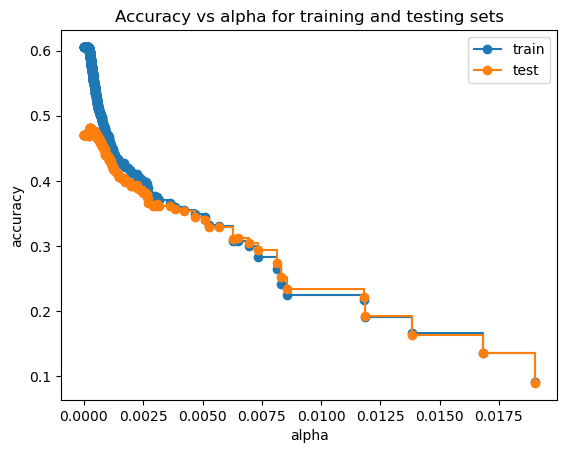

In [41]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [42]:
dtp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.006, **random_search.best_params_)
dtp.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.006, max_depth=15, min_samples_leaf=10,
                       min_samples_split=30, random_state=0)

In [43]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Test Accuracy 0.4702222222222222
Test F1-score [0.28256071 0.64634146 0.51143451 0.34538153 0.29450549 0.48870637
 0.53080569 0.57582418 0.44720497 0.3681592  0.29598309 0.33488372
 0.60849057 0.47342995 0.5255814  0.40088106 0.78241758 0.28372093
 0.75164835 0.44226044]


In [44]:
y_test_pred = dtp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.3293333333333333


In [45]:
print(classification_report(y_test, y_test_pred))

               precision    recall  f1-score   support

     afrobeat       0.00      0.00      0.00       225
  black-metal       0.89      0.48      0.63       225
    bluegrass       0.20      0.54      0.29       225
       brazil       0.10      0.04      0.06       225
    breakbeat       0.00      0.00      0.00       225
chicago-house       0.40      0.56      0.47       225
       disney       0.00      0.00      0.00       225
        forro       0.28      0.60      0.38       225
        happy       0.00      0.00      0.00       225
          idm       0.00      0.00      0.00       225
       indian       0.00      0.00      0.00       225
   industrial       0.13      0.44      0.21       225
      iranian       0.55      0.53      0.54       225
      j-dance       0.44      0.49      0.46       225
       j-idol       0.34      0.56      0.42       225
     mandopop       0.24      0.56      0.33       225
        sleep       0.90      0.66      0.76       225
      spa

C:\Users\matti\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\matti\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


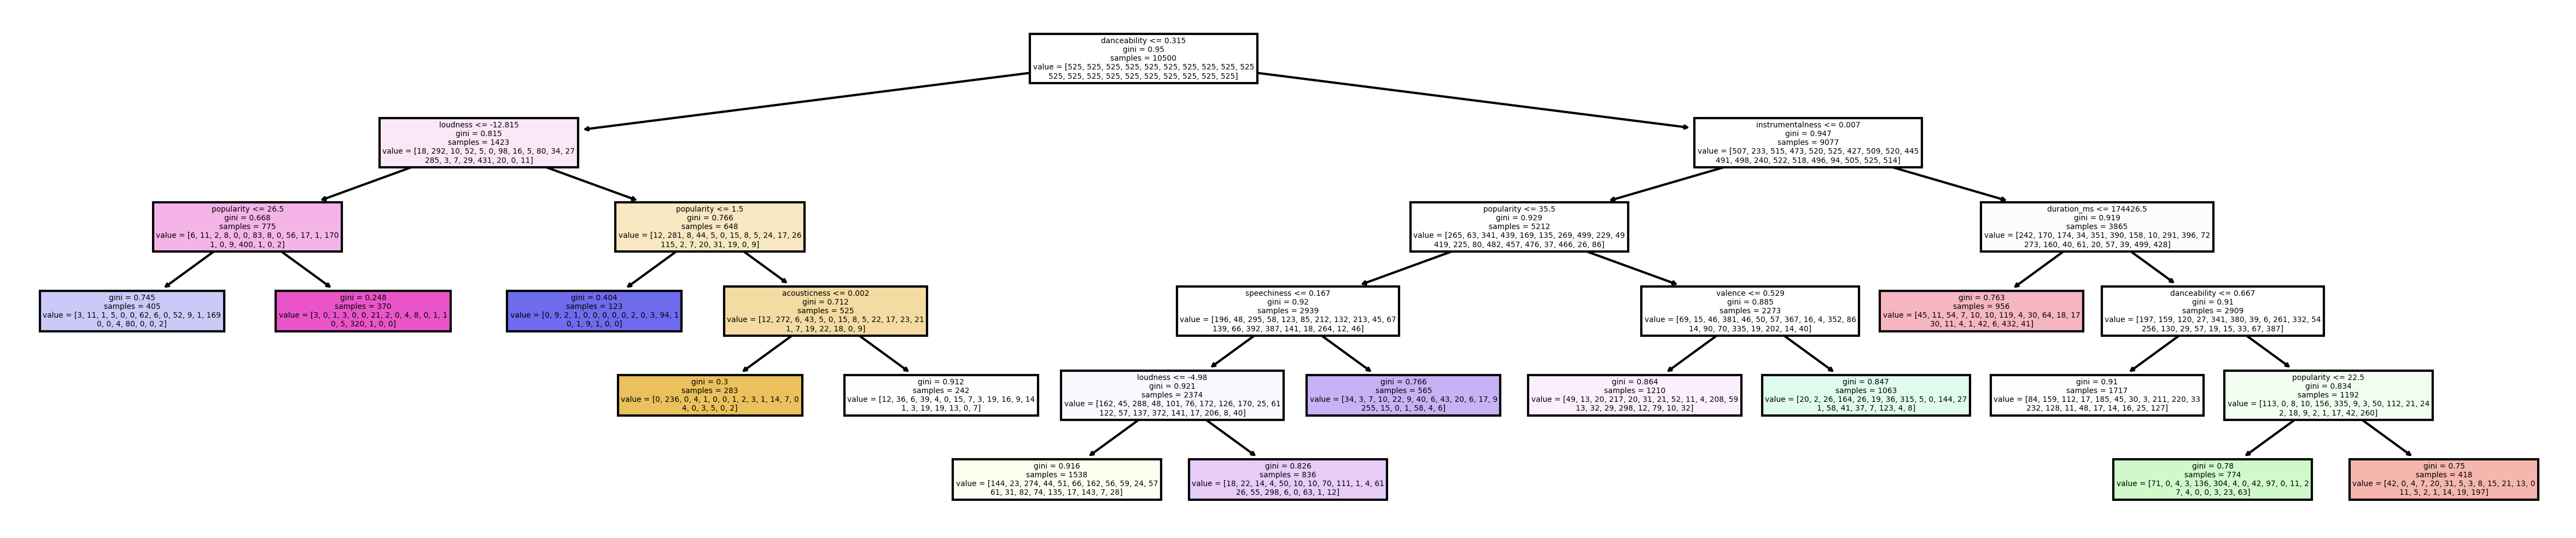

In [46]:
plt.figure(figsize=(20, 4), dpi=300)
plot_tree(dtp, feature_names=attributes, filled=True)
plt.show()

In [47]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

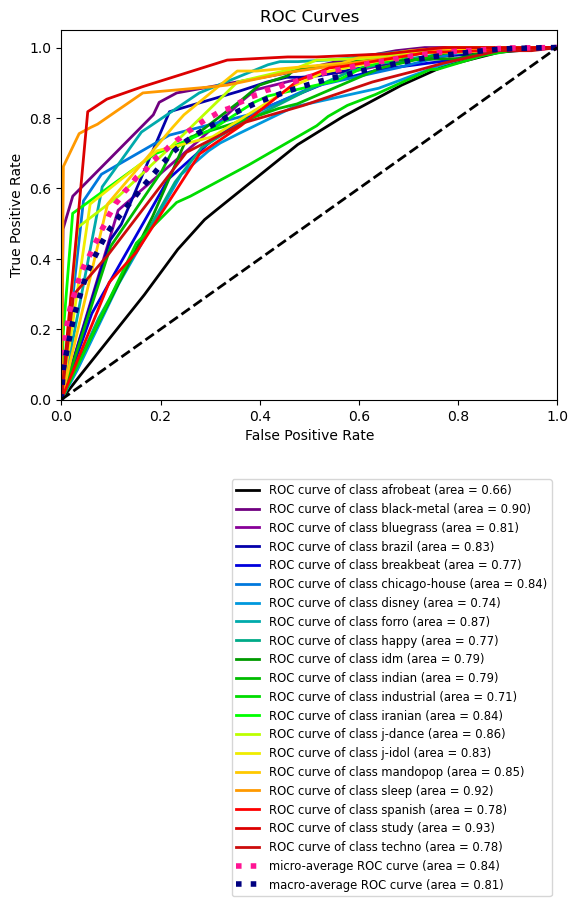

In [51]:
plot_roc(y_test, dtp.predict_proba(X_test))
plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1,-0.2))
plt.show()

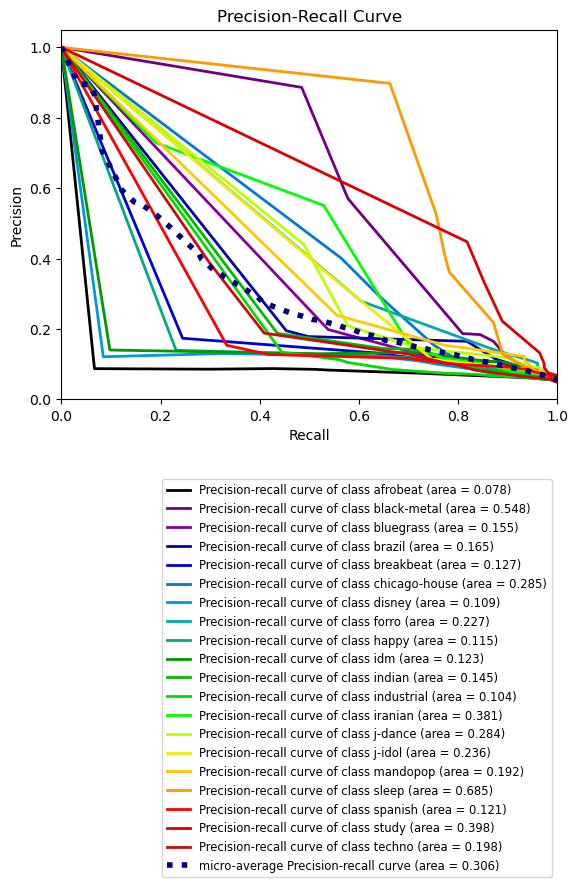

In [50]:
plot_precision_recall(y_test, dtp.predict_proba(X_test))
plt.legend(loc='upper right', fontsize='small', bbox_to_anchor=(1,-0.2))
plt.show()